<a href="https://colab.research.google.com/github/KaiserKyle/IST-718-Final-Project/blob/master/Data_Analysis_Who's_In.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  # 2D plotting
from matplotlib.cbook import boxplot_stats
import seaborn as sns 

In [3]:
data = pd.read_csv('https://raw.githubusercontent.com/KaiserKyle/IST-718-Final-Project/master/agg_team_stats.csv' ,low_memory=False)
data = data.drop(['name', 'market', 'alias','conf_id','division_alias','conf_name'], axis=1)
data['win_perc'] = data.Win / (data.Win + data.Loss)
data = data.drop(['Win','Loss'], axis = 1)
data.fillna(0, inplace=True)
conf_encode = pd.get_dummies(data['conf_alias'])
data = pd.concat([data, conf_encode], axis = 1)
data.head()

,season,team_id,conf_alias,points_game,field_goals_made,field_goals_att,field_goals_pct,three_points_made,three_points_att,three_points_pct,two_points_made,two_points_att,two_points_pct,blocked_att,free_throws_made,free_throws_att,free_throws_pct,offensive_rebounds,defensive_rebounds,rebounds,assists,turnovers,steals,blocks,assists_turnover_ratio,personal_fouls,ejections,foulouts,points,fast_break_pts,second_chance_pts,team_turnovers,points_off_turnovers,team_rebounds,flagrant_fouls,player_tech_fouls,team_tech_fouls,coach_tech_fouls,opp_points_game,opp_field_goals_pct,...,NCAA,Conference,Conf_Win,Conf_Loss,Win_Perc,Conf_Win_Perc,Conference_Champ,win_perc,A10,AAC,ACC,AE,AS,BIG10,BIG12,BIGEAST,BIGSKY,BIGSOUTH,BIGWEST,COLONIAL,CUSA,HORIZON,IVY,MAAC,MAC,MEAC,MVC,MWC,NE,OVC,PAC12,PATRIOT,SEC,SOUTHERN,SOUTHLAND,SUMMIT,SUNBELT,SWAC,WAC,WCC
0,2013,8ddbfca9-a931-4908-aa31-9fcd17624b5f,CUSA,71.451613,22.25,60.500000,36.75,5.500000,16.000000,34.875000,16.750000,44.5,37.650000,5.000000,12.0,18.250000,64.85,13.500000,23.000000,36.500000,10.250000,15.000000,6.000000,2.250000,0.782500,18.750000,0.0,2.0,62.000000,5.000000,10.000000,0.75,10.750000,3.0,0.000000,0.75,0.0,0.0,71.645161,41.925,...,False,True,7.0,8.0,0.548387,0.466667,False,0.548387,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2013,11a617d5-af03-4cce-bc8a-51114d9e41fe,BIGWEST,69.741935,23.20,59.200000,38.83,5.400000,19.600000,27.410000,17.800000,39.6,44.050000,2.900000,11.0,17.900000,59.79,10.500000,19.300000,29.800000,11.000000,11.900000,5.400000,2.000000,0.989000,18.400000,0.0,0.0,62.800000,6.555556,10.600000,0.30,10.900000,3.9,0.000000,0.00,0.0,0.0,70.580645,47.450,...,False,True,10.0,7.0,0.451613,0.588235,False,0.451613,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2013,d8217105-e9c2-4267-9538-3aaeea1ae167,MVC,69.393939,22.00,53.333333,41.65,4.666667,13.333333,35.916667,17.333333,40.0,43.733333,5.333333,11.0,17.166667,65.50,5.666667,21.666667,27.333333,13.333333,13.833333,4.333333,3.666667,1.013333,21.333333,0.0,0.0,59.666667,5.500000,6.833333,0.40,7.666667,4.8,0.166667,0.00,0.0,0.0,72.212121,43.350,...,False,True,8.0,10.0,0.424242,0.444444,False,0.424242,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2013,5016fe1a-9571-4d10-bf5b-b9c1b496bd57,WAC,77.228571,20.00,52.500000,37.50,4.000000,14.000000,26.750000,16.000000,38.5,41.150000,4.000000,14.0,20.000000,69.70,9.000000,13.500000,22.500000,10.500000,13.500000,6.000000,4.000000,0.840000,15.000000,0.0,0.0,58.000000,5.000000,7.500000,0.00,17.000000,3.5,0.500000,0.00,0.0,0.0,66.914286,50.150,...,True,True,13.0,3.0,0.742857,0.812500,True,0.742857,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,2013,53aaac6a-796e-41a6-a04e-6ce74c5717f8,MEAC,65.281250,16.00,48.500000,32.75,7.000000,19.500000,34.500000,9.000000,29.0,31.200000,0.500000,21.5,30.000000,71.80,8.500000,22.500000,31.000000,12.000000,16.000000,2.500000,3.000000,0.790000,26.500000,0.0,0.0,60.500000,7.000000,7.000000,1.50,3.500000,4.5,0.000000,0.00,0.0,0.0,73.187500,47.450,...,False,True,5.0,12.0,0.281250,0.294118,False,0.281250,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


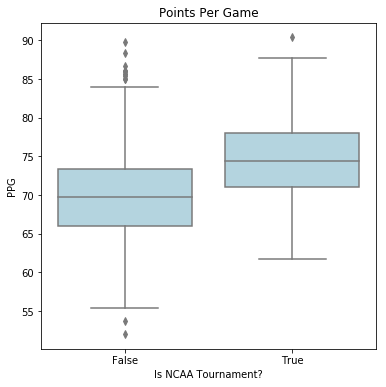

In [4]:
plt.rcParams['figure.figsize'] = [6, 6]
g = sns.boxplot(x="NCAA", y="points_game", data=data, color = "lightblue")
g.set(xlabel = "Is NCAA Tournament?", ylabel = "PPG")
g.set_title("Points Per Game")

plt.show()

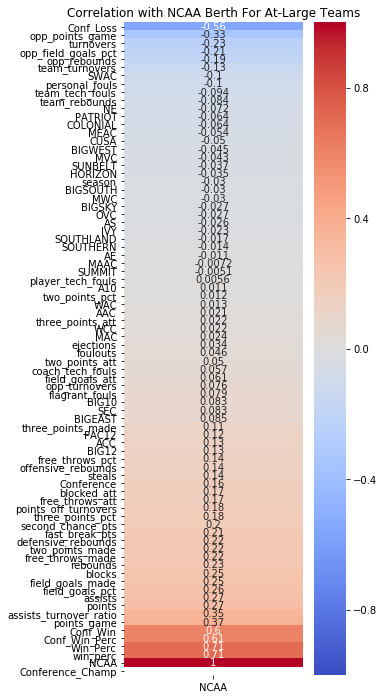

In [5]:
at_large_data = data[data.Conference_Champ == False]

plt.rcParams['figure.figsize'] = [4, 12]
corr = at_large_data.corr()
corr = corr.loc[['NCAA']].transpose().sort_values(by = 'NCAA')
g = sns.heatmap(corr, 
            yticklabels=corr.index.values,
            annot = True,
            center = 0,
            vmin = -1,
            vmax = 1,
            cmap = 'coolwarm')

plt.title("Correlation with NCAA Berth For At-Large Teams")

plt.show()

In [6]:
train_data = at_large_data[(at_large_data['season'] == 2013) | (at_large_data['season'] == 2014) | (at_large_data['season'] == 2015)]
test_data = at_large_data[(at_large_data['season'] == 2016) | (at_large_data['season'] == 2017)]

y_test = test_data[['NCAA', 'season', 'team_id']]
y_train = train_data[['NCAA', 'season', 'team_id']]
X_test = test_data.drop(['NCAA', 'season', 'team_id', 'conf_alias'], axis=1)
X_train = train_data.drop(['NCAA', 'season', 'team_id', 'conf_alias'], axis=1)

X_train.head()

,points_game,field_goals_made,field_goals_att,field_goals_pct,three_points_made,three_points_att,three_points_pct,two_points_made,two_points_att,two_points_pct,blocked_att,free_throws_made,free_throws_att,free_throws_pct,offensive_rebounds,defensive_rebounds,rebounds,assists,turnovers,steals,blocks,assists_turnover_ratio,personal_fouls,ejections,foulouts,points,fast_break_pts,second_chance_pts,team_turnovers,points_off_turnovers,team_rebounds,flagrant_fouls,player_tech_fouls,team_tech_fouls,coach_tech_fouls,opp_points_game,opp_field_goals_pct,opp_rebounds,opp_turnovers,Conference,Conf_Win,Conf_Loss,Win_Perc,Conf_Win_Perc,Conference_Champ,win_perc,A10,AAC,ACC,AE,AS,BIG10,BIG12,BIGEAST,BIGSKY,BIGSOUTH,BIGWEST,COLONIAL,CUSA,HORIZON,IVY,MAAC,MAC,MEAC,MVC,MWC,NE,OVC,PAC12,PATRIOT,SEC,SOUTHERN,SOUTHLAND,SUMMIT,SUNBELT,SWAC,WAC,WCC
0,71.451613,22.25000,60.500000,36.750,5.500000,16.000000,34.875000,16.750000,44.50000,37.650000,5.000000,12.00000,18.250000,64.8500,13.500000,23.000000,36.500000,10.250000,15.000000,6.000000,2.250000,0.782500,18.750000,0.0,2.0,62.000000,5.000000,10.000000,0.75,10.750000,3.0,0.000000,0.750,0.0,0.0,71.645161,41.925000,37.50000,12.250000,True,7.0,8.0,0.548387,0.466667,False,0.548387,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,69.741935,23.20000,59.200000,38.830,5.400000,19.600000,27.410000,17.800000,39.60000,44.050000,2.900000,11.00000,17.900000,59.7900,10.500000,19.300000,29.800000,11.000000,11.900000,5.400000,2.000000,0.989000,18.400000,0.0,0.0,62.800000,6.555556,10.600000,0.30,10.900000,3.9,0.000000,0.000,0.0,0.0,70.580645,47.450000,35.40000,11.500000,True,10.0,7.0,0.451613,0.588235,False,0.451613,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,69.393939,22.00000,53.333333,41.650,4.666667,13.333333,35.916667,17.333333,40.00000,43.733333,5.333333,11.00000,17.166667,65.5000,5.666667,21.666667,27.333333,13.333333,13.833333,4.333333,3.666667,1.013333,21.333333,0.0,0.0,59.666667,5.500000,6.833333,0.40,7.666667,4.8,0.166667,0.000,0.0,0.0,72.212121,43.350000,38.50000,11.166667,True,8.0,10.0,0.424242,0.444444,False,0.424242,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,65.281250,16.00000,48.500000,32.750,7.000000,19.500000,34.500000,9.000000,29.00000,31.200000,0.500000,21.50000,30.000000,71.8000,8.500000,22.500000,31.000000,12.000000,16.000000,2.500000,3.000000,0.790000,26.500000,0.0,0.0,60.500000,7.000000,7.000000,1.50,3.500000,4.5,0.000000,0.000,0.0,0.0,73.187500,47.450000,33.50000,9.500000,True,5.0,12.0,0.281250,0.294118,False,0.281250,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,65.156250,22.96875,53.562500,43.025,5.812500,18.093750,32.156250,17.156250,35.46875,48.706250,3.906250,13.40625,20.843750,65.2375,7.968750,22.500000,30.468750,12.781250,11.031250,6.500000,3.968750,1.291875,18.125000,0.0,0.0,65.156250,7.178571,8.000000,0.25,13.437500,3.0,0.031250,0.125,0.0,0.0,63.437500,40.409375,32.96875,13.125000,True,8.0,11.0,0.531250,0.421053,False,0.531250,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [7]:
from sklearn import linear_model
clf = linear_model.SGDClassifier(max_iter=1000)
clf.fit(X_train, y_train.NCAA)
clf.score(X_test, y_test.NCAA)

0.8426791277258567

In [8]:
from sklearn.svm import SVC
clf = SVC()
clf.fit(X_train, y_train.NCAA)
clf.score(X_test, y_test.NCAA)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.7570093457943925

In [9]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train.NCAA)
neigh.score(X_test, y_test.NCAA)

0.7227414330218068

In [10]:
from sklearn.ensemble import RandomForestClassifier 

forest = RandomForestClassifier(n_estimators = 500)
forest.fit(X_train, y_train.NCAA)
print('Random Forest Score: ', forest.score(X_test, y_test.NCAA))

predictions = pd.DataFrame(forest.predict_proba(X_test))

predictions['Actual'] = y_test.NCAA.values
predictions['Season'] = y_test.season.values
predictions.sort_values(by = 1, ascending = False, inplace = True)

pred_2016 = predictions[predictions['Season'] == 2016]
pred_2017 = predictions[predictions['Season'] == 2017]

in_2016 = pred_2016.head(36)
in_2017 = pred_2017.head(36)

print("2016 Top 36 at-large bid accuracy: ", in_2016.Actual.mean())
print("2017 Top 36 at-large bid accuracy: ", in_2017.Actual.mean())

Random Forest Score:  0.8473520249221184
2016 Top 36 at-large bid accuracy:  0.9166666666666666
2017 Top 36 at-large bid accuracy:  0.8611111111111112


In [12]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler

print(X_train.shape)

def create_baseline():
	# create model
  model = Sequential()
  model.add(Dense(78, input_dim=78, kernel_initializer='normal', activation='relu'))
  model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
	# Compile model
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scale = scaler.transform(X_train)
X_test_scale = scaler.transform(X_test)

X_train_scale

(967, 78)


array([[ 0.22833391, -0.43264178,  0.77363942, ..., -0.1694798 ,
        -0.14899239, -0.1694798 ],
       [-0.074585  , -0.14104308,  0.56009006, ..., -0.1694798 ,
        -0.14899239, -0.1694798 ],
       [-0.13624259, -0.50937828, -0.40361984, ..., -0.1694798 ,
        -0.14899239, -0.1694798 ],
       ...,
       [ 1.03421253,  0.76956338,  0.88862753, ..., -0.1694798 ,
         6.71175231, -0.1694798 ],
       [ 0.54562805,  0.94163917,  0.69648289, ..., -0.1694798 ,
        -0.14899239, -0.1694798 ],
       [ 1.21660266,  0.75451701,  0.69633648, ..., -0.1694798 ,
        -0.14899239, -0.1694798 ]])

In [13]:
%%time

model = create_baseline()

# FIT THE MODEL
history  = model.fit(X_train_scale, y_train.NCAA, validation_data=(X_test_scale, y_test.NCAA), epochs=400, batch_size=10000, verbose=2)

# EVALUATE THE MODEL
scores = model.evaluate(X_test_scale, y_test.NCAA, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 967 samples, validate on 642 samples
Epoch 1/400
 - 1s - loss: 0.6942 - acc: 0.4757 - val_loss: 0.6817 - val_acc: 0.5405
Epoch 2/400
 - 0s - loss: 0.6856 - acc: 0.5284 - val_loss: 0.6750 - val_acc: 0.5779
Epoch 3/400
 - 0s - loss: 0.6760 - acc: 0.5884 - val_loss: 0.6680 - val_acc: 0.6184
Epoch 4/400
 - 0s - loss: 0.6662 - acc: 0.6391 - val_loss: 0.6609 - val_acc: 0.6417
Epoch 5/400
 - 0s - loss: 0.6564 - acc: 0.6753 - val_loss: 0.6539 - val_acc: 0.6667
Epoch 6/400
 - 0s - loss: 0.6467 - acc: 0.6970 - val_loss: 0.6470 - val_acc: 0.6900
Epoch 7/400
 - 0s - loss: 0.6372 - acc: 0.7239 - val_loss: 0.6401 - val_acc: 0.7056
Epoch 8/400
 - 0s - loss: 0.6279 - acc: 0.7477 - val_loss: 0.6333 - val_acc: 0.7165
Epoch 9/400
 - 0s - loss: 0.6187 - acc: 0.7611 - val_loss: 0.6267 - val_acc: 0.7243
Epoch 10/400
 - 0s - loss: 0.6098 - acc: 0.7673 - val_loss: 0.6202 - val_acc: 

In [14]:
y_hat = model.predict_proba(X_test_scale)

predictions = pd.DataFrame(y_hat)

predictions['Actual'] = y_test.NCAA.values
predictions['Season'] = y_test.season.values
predictions['Team'] = y_test.team_id.values

predictions.sort_values(by = 0, ascending = False, inplace = True)

#print(predictions.head(75))

pred_2016 = predictions[predictions['Season'] == 2016]
pred_2017 = predictions[predictions['Season'] == 2017]

in_2016 = pred_2016.head(36)
in_2017 = pred_2017.head(36)

print("2016 Top 36 at-large bid accuracy: ", in_2016.Actual.mean())
print("2017 Top 36 at-large bid accuracy: ", in_2017.Actual.mean())

2016 Top 36 at-large bid accuracy:  0.9444444444444444
2017 Top 36 at-large bid accuracy:  0.8611111111111112
